In [11]:
#download data and unzip
!wget -O  data/hymenoptera_data.zip https://download.pytorch.org/tutorial/hymenoptera_data.zip 
!unzip data/hymenoptera_data.zip -d data/


--2024-06-24 09:42:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.46.30, 108.156.46.129, 108.156.46.108, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.46.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

data/hymenoptera_da 100%[===================>]  45.10M  40.4MB/s    in 1.1s    

2024-06-24 09:42:43 (40.4 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in ['train', 'val']}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


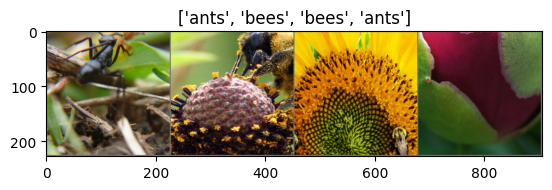

In [15]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_features = model.fc.in_features
print('Num Features:', num_features)
#freeze layers
for param in model.parameters():
    param.requires_grad = False

num_classes = 2 # bees/ants
num_epochs = 15
lr = 0.03
model.fc = nn.Linear(num_features, num_classes) # replace the final layer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9) # only training fc layer
# reduce learning rate by 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

Num Features: 512


In [26]:
from utils.train import train_model

model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    num_epochs=num_epochs,
    device='cuda',
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'])

Using: cuda
Epoch 0/14
----------


100%|██████████| 61/61 [00:01<00:00, 60.85it/s]


train Loss: 2.0633 Acc: 214/244 = 0.8770


100%|██████████| 39/39 [00:00<00:00, 76.53it/s]


val Loss: 2.7679 Acc: 139/153 = 0.9085
New best accuracy: 0.908

Epoch 1/14
----------


100%|██████████| 61/61 [00:00<00:00, 77.87it/s]


train Loss: 3.0207 Acc: 206/244 = 0.8443


100%|██████████| 39/39 [00:00<00:00, 77.37it/s]


val Loss: 1.4569 Acc: 143/153 = 0.9346
New best accuracy: 0.935

Epoch 2/14
----------


100%|██████████| 61/61 [00:00<00:00, 74.38it/s]


train Loss: 3.2918 Acc: 205/244 = 0.8402


100%|██████████| 39/39 [00:00<00:00, 74.29it/s]


val Loss: 1.3680 Acc: 142/153 = 0.9281

Epoch 3/14
----------


100%|██████████| 61/61 [00:00<00:00, 79.02it/s]


train Loss: 3.2667 Acc: 198/244 = 0.8115


100%|██████████| 39/39 [00:00<00:00, 69.54it/s]


val Loss: 1.7414 Acc: 142/153 = 0.9281

Epoch 4/14
----------


100%|██████████| 61/61 [00:00<00:00, 76.83it/s]


train Loss: 2.6493 Acc: 203/244 = 0.8320


100%|██████████| 39/39 [00:00<00:00, 75.38it/s]


val Loss: 1.4046 Acc: 141/153 = 0.9216

Epoch 5/14
----------


100%|██████████| 61/61 [00:00<00:00, 81.16it/s]


train Loss: 2.1970 Acc: 212/244 = 0.8689


100%|██████████| 39/39 [00:00<00:00, 77.62it/s]


val Loss: 1.4854 Acc: 144/153 = 0.9412
New best accuracy: 0.941

Epoch 6/14
----------


100%|██████████| 61/61 [00:00<00:00, 78.53it/s]


train Loss: 1.3895 Acc: 217/244 = 0.8893


100%|██████████| 39/39 [00:00<00:00, 73.99it/s]


val Loss: 1.4349 Acc: 143/153 = 0.9346

Epoch 7/14
----------


100%|██████████| 61/61 [00:00<00:00, 79.02it/s]


train Loss: 2.0386 Acc: 211/244 = 0.8648


100%|██████████| 39/39 [00:00<00:00, 71.82it/s]


val Loss: 1.3187 Acc: 142/153 = 0.9281

Epoch 8/14
----------


100%|██████████| 61/61 [00:00<00:00, 79.71it/s]


train Loss: 2.2799 Acc: 207/244 = 0.8484


100%|██████████| 39/39 [00:00<00:00, 78.05it/s]


val Loss: 1.6635 Acc: 143/153 = 0.9346

Epoch 9/14
----------


100%|██████████| 61/61 [00:00<00:00, 82.21it/s]


train Loss: 1.8398 Acc: 214/244 = 0.8770


100%|██████████| 39/39 [00:00<00:00, 74.22it/s]


val Loss: 1.5069 Acc: 143/153 = 0.9346

Epoch 10/14
----------


100%|██████████| 61/61 [00:00<00:00, 74.28it/s]


train Loss: 3.2152 Acc: 195/244 = 0.7992


100%|██████████| 39/39 [00:00<00:00, 78.62it/s]


val Loss: 1.8099 Acc: 142/153 = 0.9281

Epoch 11/14
----------


100%|██████████| 61/61 [00:00<00:00, 74.99it/s]


train Loss: 1.9639 Acc: 209/244 = 0.8566


100%|██████████| 39/39 [00:00<00:00, 76.51it/s]


val Loss: 1.7923 Acc: 144/153 = 0.9412

Epoch 12/14
----------


100%|██████████| 61/61 [00:00<00:00, 83.51it/s]


train Loss: 2.2316 Acc: 210/244 = 0.8607


100%|██████████| 39/39 [00:00<00:00, 77.89it/s]


val Loss: 1.3734 Acc: 143/153 = 0.9346

Epoch 13/14
----------


100%|██████████| 61/61 [00:00<00:00, 77.01it/s]


train Loss: 1.5076 Acc: 218/244 = 0.8934


100%|██████████| 39/39 [00:00<00:00, 73.83it/s]


val Loss: 1.6424 Acc: 143/153 = 0.9346

Epoch 14/14
----------


100%|██████████| 61/61 [00:00<00:00, 78.02it/s]


train Loss: 2.4278 Acc: 207/244 = 0.8484


100%|██████████| 39/39 [00:00<00:00, 71.54it/s]

val Loss: 1.4283 Acc: 140/153 = 0.9150

Training complete in 0m 20s
Best val Acc: 0.941176
